<a href="https://www.kaggle.com/code/klaidenx/p-s3e16-eda-model?scriptVersionId=131999215" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
warnings.filterwarnings("ignore")                                                        

/kaggle/input/playground-series-s3e16/sample_submission.csv
/kaggle/input/playground-series-s3e16/train.csv
/kaggle/input/playground-series-s3e16/test.csv


In [2]:
from sklearn.preprocessing import RobustScaler,StandardScaler,OneHotEncoder,LabelEncoder
from sklearn.model_selection import GridSearchCV,train_test_split as tts
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,r2_score
from xgboost import XGBRegressor

<h2 style="color:#00DFA2">Data Reading & Overview</h2>

In [3]:
#Path to files
path="../input/playground-series-s3e16/"
#Reading Data
train_df=pd.read_csv(path+"train.csv")
test_df=pd.read_csv(path+"test.csv")
sub_sample=pd.read_csv(path+"sample_submission.csv")

In [4]:
train_df.head()

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74051 entries, 0 to 74050
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              74051 non-null  int64  
 1   Sex             74051 non-null  object 
 2   Length          74051 non-null  float64
 3   Diameter        74051 non-null  float64
 4   Height          74051 non-null  float64
 5   Weight          74051 non-null  float64
 6   Shucked Weight  74051 non-null  float64
 7   Viscera Weight  74051 non-null  float64
 8   Shell Weight    74051 non-null  float64
 9   Age             74051 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 5.6+ MB


In [6]:
train_df.iloc[:,1:].describe().T.style.background_gradient(subset='mean',cmap='coolwarm')\
                                      .background_gradient(subset='min',cmap='coolwarm')\
                                      .background_gradient(subset='max',cmap='coolwarm')

,count,mean,std,min,25%,50%,75%,max
Length,74051.000000,1.317460,0.287757,0.187500,1.150000,1.375000,1.537500,2.012815
Diameter,74051.000000,1.024496,0.237396,0.137500,0.887500,1.075000,1.200000,1.612500
Height,74051.000000,0.348089,0.092034,0.000000,0.300000,0.362500,0.412500,2.825000
Weight,74051.000000,23.385217,12.648153,0.056699,13.437663,23.799405,32.162508,80.101512
Shucked Weight,74051.000000,10.104270,5.618025,0.028349,5.712424,9.908150,14.033003,42.184056
Viscera Weight,74051.000000,5.058386,2.792729,0.042524,2.863300,4.989512,6.988152,21.545620
Shell Weight,74051.000000,6.723870,3.584372,0.042524,3.968930,6.931453,9.071840,28.491248
Age,74051.000000,9.967806,3.175189,1.000000,8.000000,10.000000,11.000000,29.000000


In [7]:
#Checking For Missing Data
missing_data=train_df.isna().sum().sum()
print(f"There is a total of {missing_data} Missing data")

There is a total of 0 Missing data


In [8]:
sex_count=train_df["Sex"].value_counts().to_frame().T
sex_count

,M,I,F
Sex,27084,23957,23010


<h2 style="color:#00DFA2">Data Visualization</h2>

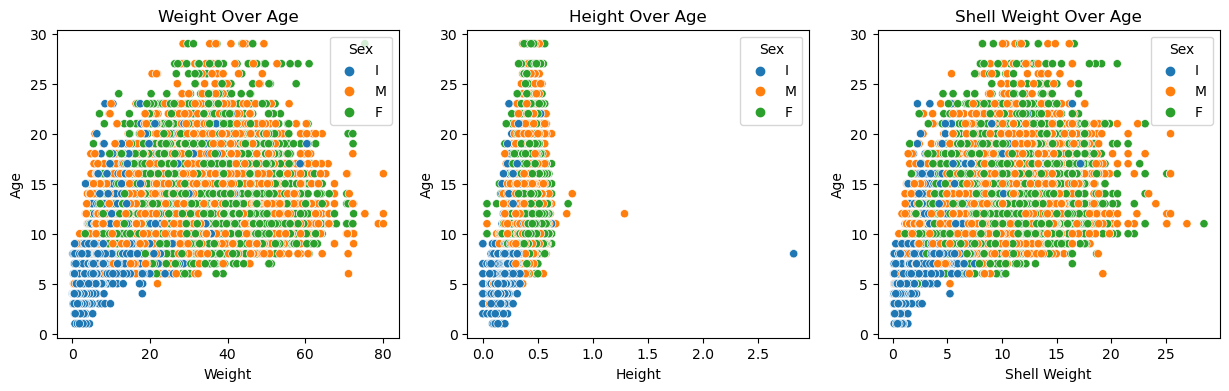

In [9]:

fig,axs=plt.subplots(1,3,figsize=(15,4))
sns.scatterplot(ax=axs[0],data=train_df,x='Weight',y='Age',hue="Sex")
axs[0].set_title("Weight Over Age")
sns.scatterplot(ax=axs[1],data=train_df,x='Height',y='Age',hue="Sex")
axs[1].set_title("Height Over Age")
sns.scatterplot(ax=axs[2],data=train_df,x='Shell Weight',y='Age',hue="Sex")
axs[2].set_title("Shell Weight Over Age")
plt.show()

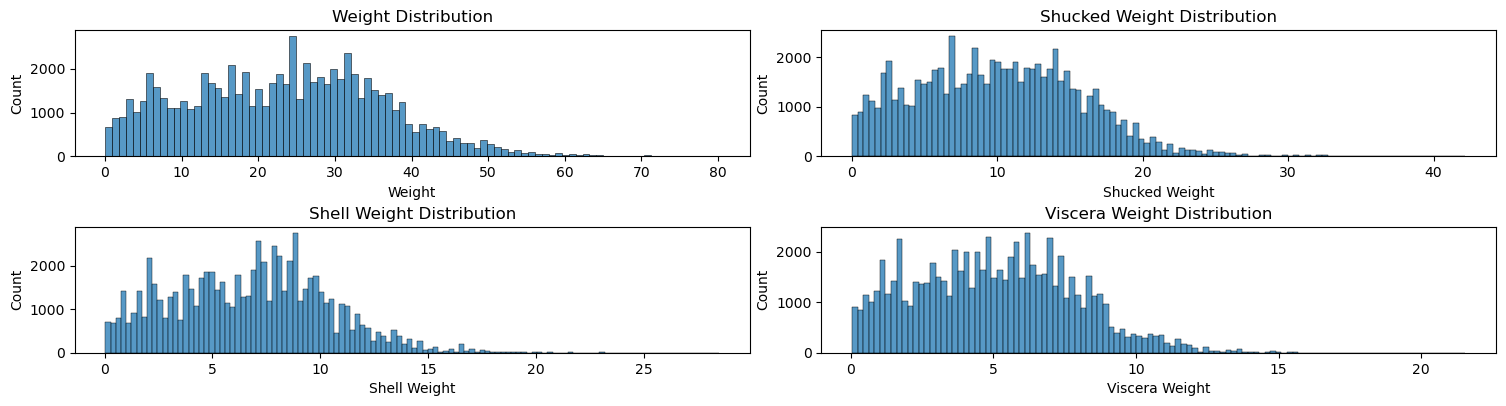

In [10]:
fig,axs=plt.subplots(2,2,figsize=(15,4))
sns.histplot(ax=axs[0,0],data=train_df,x="Weight")
axs[0,0].set_title("Weight Distribution")

sns.histplot(ax=axs[0,1],data=train_df,x="Shucked Weight")
axs[0,1].set_title("Shucked Weight Distribution")

sns.histplot(ax=axs[1,0],data=train_df,x="Shell Weight")
axs[1,0].set_title("Shell Weight Distribution")

sns.histplot(ax=axs[1,1],data=train_df,x="Viscera Weight")
axs[1,1].set_title("Viscera Weight Distribution")

plt.tight_layout(pad=.5)
plt.show()

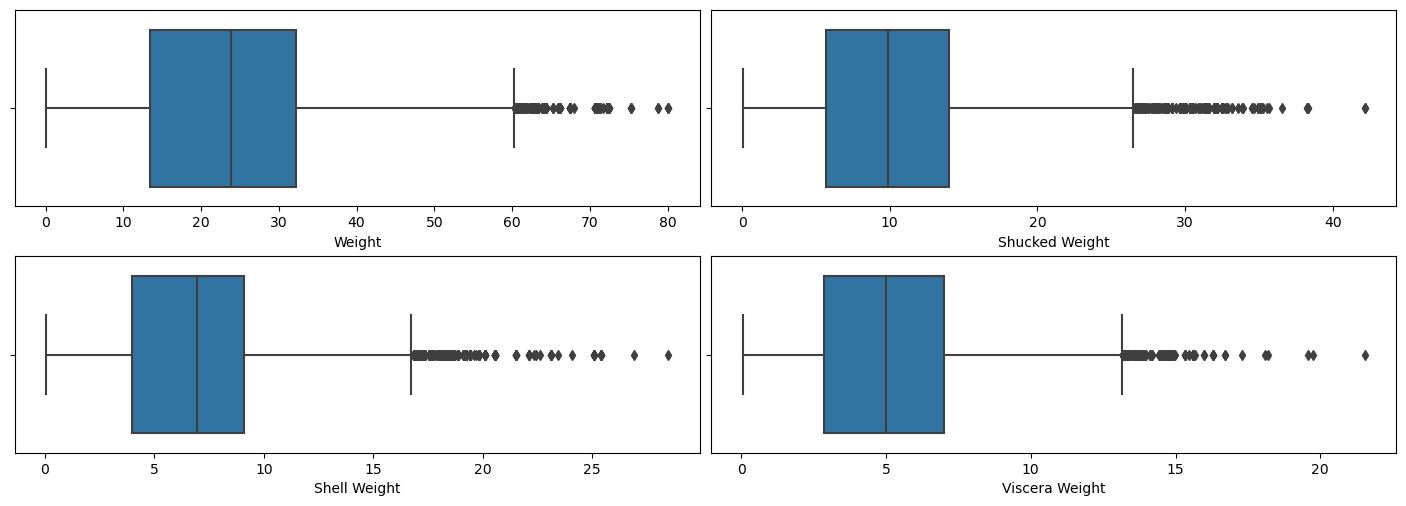

In [11]:
fig,axs=plt.subplots(2,2,figsize=(14,5))
sns.boxplot(ax=axs[0,0],data=train_df,x="Weight")

sns.boxplot(ax=axs[0,1],data=train_df,x="Shucked Weight")

sns.boxplot(ax=axs[1,0],data=train_df,x="Shell Weight")

sns.boxplot(ax=axs[1,1],data=train_df,x="Viscera Weight")
plt.tight_layout(pad=.5)
plt.show()

<h2 style="color:#00DFA2">Data Preparation</h2>

In [12]:
train_df.duplicated().sum()

0

In [13]:
#Drop The Id column
train_df.drop(columns=['id'],inplace=True)

#Encoders
encoder=LabelEncoder()
stc=StandardScaler()
rstc=RobustScaler()

#Transform The Data
train_df['Sex']=encoder.fit_transform(train_df[["Sex"]])
train_df['Weight']=stc.fit_transform(train_df["Weight"].values.reshape(-1,1))
train_df['Shucked Weight']=rstc.fit_transform(train_df["Shucked Weight"].values.reshape(-1,1))
train_df['Shell Weight']=rstc.fit_transform(train_df["Shell Weight"].values.reshape(-1,1))
train_df['Viscera Weight']=rstc.fit_transform(train_df["Viscera Weight"].values.reshape(-1,1))

In [14]:
train_df

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,1,1.5250,1.1750,0.3750,0.441804,0.339012,0.402062,0.277778,9
1,1,1.1000,0.8250,0.2750,-1.025198,-0.647359,-0.646048,-0.691667,8
2,2,1.3875,1.1125,0.3750,0.110076,0.172061,0.137457,-0.052778,9
3,0,1.7000,1.4125,0.5000,2.156483,1.255537,1.455162,1.580556,11
4,1,1.2500,1.0125,0.3375,-0.007598,0.248722,-0.116838,-0.191667,8
...,...,...,...,...,...,...,...,...,...
74046,0,1.6625,1.2625,0.4375,2.156483,1.294719,1.302405,1.058333,10
74047,1,1.0750,0.8625,0.2750,-1.022957,-0.671210,-0.652921,-0.663889,6
74048,0,1.4875,1.2000,0.4125,0.482150,0.287905,0.618557,0.225000,10
74049,1,1.2125,0.9625,0.3125,-0.523122,-0.112436,-0.501718,-0.519444,8


In [15]:
X,y=train_df.drop(columns=['Age']),train_df.loc[:,'Age']

<h2 style="color:#00DFA2">Model</h2>

In [16]:
X_train,X_test,y_train,y_test=tts(X,y,test_size=.2,random_state=0)

In [17]:
lr=LinearRegression()
lr.fit(X_train,y_train)
y_hat=lr.predict(X_test)
mae=mean_absolute_error(y_test,y_hat)
r2=r2_score(y_test,y_hat)
print(f"Mean Absolute Error {mae} And R2 Score {r2}")

Mean Absolute Error 1.5076013581485237 And R2 Score 0.5378696652753465


<h2 style="color:#00DFA2">Testing And Submission</h2>

In [18]:
test_df.head()

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight
0,74051,I,1.0500,0.7625,0.2750,8.618248,3.657085,1.729319,2.721552
1,74052,I,1.1625,0.8875,0.2750,15.507176,7.030676,3.246018,3.968930
2,74053,F,1.2875,0.9875,0.3250,14.571643,5.556502,3.883882,4.819415
3,74054,F,1.5500,0.9875,0.3875,28.377849,13.380964,6.548735,7.030676
4,74055,I,1.1125,0.8500,0.2625,11.765042,5.528153,2.466407,3.331066


In [19]:
test_df['Sex']=encoder.fit_transform(test_df[["Sex"]])
test_df['Weight']=stc.fit_transform(test_df["Weight"].values.reshape(-1,1))
test_df['Shucked Weight']=rstc.fit_transform(test_df["Shucked Weight"].values.reshape(-1,1))
test_df['Shell Weight']=rstc.fit_transform(test_df["Shell Weight"].values.reshape(-1,1))
test_df['Viscera Weight']=rstc.fit_transform(test_df["Viscera Weight"].values.reshape(-1,1))

In [20]:
X_test_df=test_df.drop(columns=['id'])
y_pred=lr.predict(X_test_df)

In [21]:
new_submission={
    "id":test_df['id'].values,
    "Age":y_pred
}
submission=pd.DataFrame(new_submission)

In [22]:
submission

,id,Age
0,74051,8.125599
1,74052,8.181253
2,74053,10.042669
3,74054,9.219199
4,74055,7.952356
...,...,...
49363,123414,9.050896
49364,123415,8.223765
49365,123416,12.150148
49366,123417,9.571473


In [23]:
submission.to_csv("submission.csv",index=False)